In [1]:

# ref
# X https://github.com/altosaar/variational-autoencoder/blob/master/train_variational_autoencoder_tensorflow.py
# X https://github.com/kvfrans/variational-autoencoder

# Good 
# https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

# Best toturial
# https://arxiv.org/pdf/1606.05908.pdf

# implementation
# Offical
# https://medium.com/tensorflow/variational-autoencoders-with-tensorflow-probability-layers-d06c658931b7

# https://danijar.com/building-variational-auto-encoders-in-tensorflow/
# https://docs.google.com/presentation/d/1VSNlkGcR-b39tMcuREjzZdhYOPvoZudpcbuNlf5hOIM/edit#slide=id.g30fdd2f6e9_0_72


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
import math

# compress dim by using tSNE
from sklearn.manifold import TSNE
plt.style.use('default')

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [4]:
with open('hw4_tr7.pkl', 'rb') as f:
    train_data_input = pickle.load(f)
with open('hw4_te7.pkl', 'rb') as f:
    test_data_input = pickle.load(f)

In [5]:
print(train_data_input.shape)
print(test_data_input.shape)

(6265, 28, 28)
(1028, 28, 28)


In [6]:
def display_digit(image, label):
    plt.title('Label: %d' % label)
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

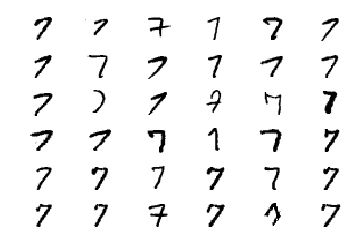

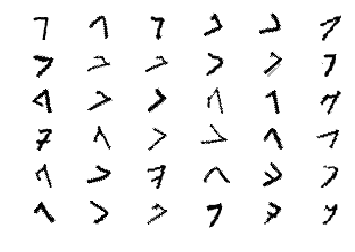

In [7]:
# Get some idea by visualizing
plt.figure()
iter = 0
for i in range(6):
    for j in range(6):
        while y_train[iter] != 7:
            iter += 1        
        ax=plt.subplot2grid((6, 6), (i, j))
        plt.imshow(x_train[iter].reshape([28,28]), cmap=plt.get_cmap('gray_r'))
        plt.axis('off')
        iter += 1
        
plt.figure()
for i in range(6):
    for j in range(6):        
        ax=plt.subplot2grid((6, 6), (i, j))
        plt.imshow(train_data_input[i*10+j].reshape([28,28]), cmap=plt.get_cmap('gray_r'))
        plt.axis('off')

In [8]:
tfd = tf.contrib.distributions

In [23]:
code_size = 4
learning_rate = 0.001
batch_size = 64
hidden_units = [
    256,
    128,
    64,
]

In [24]:
def make_encoder(data):
  x = tf.layers.flatten(data)
  x = tf.layers.dense(x, hidden_units[0], tf.nn.relu)
  x = tf.layers.dense(x, hidden_units[1], tf.nn.relu)
  x = tf.layers.dense(x, hidden_units[2], tf.nn.relu)
  mean = tf.layers.dense(x, code_size)
  stddev = tf.layers.dense(x, code_size, tf.nn.softplus)
  return tfd.MultivariateNormalDiag(mean, stddev)

In [25]:
def make_prior():
  mean = tf.zeros(code_size)
  stddev = tf.ones(code_size)
  return tfd.MultivariateNormalDiag(mean, stddev)

In [26]:
def make_decoder(code, data_shape=[28, 28]):
  x = code
  x = tf.layers.dense(x, hidden_units[2], tf.nn.relu)
  x = tf.layers.dense(x, hidden_units[1], tf.nn.relu)
  x = tf.layers.dense(x, hidden_units[0], tf.nn.relu)
  logit = tf.layers.dense(x, np.prod(data_shape))
  logit = tf.reshape(logit, [-1] + data_shape)
  return tfd.Independent(tfd.Bernoulli(logit), 2)

In [27]:
# define model
x = tf.placeholder(tf.float32, [None, 28, 28])

encoder = tf.make_template('encoder', make_encoder)
decoder = tf.make_template('decoder', make_decoder)

prior = make_prior()
posterior = encoder(x)
code = posterior.sample()

In [28]:
# define the loss
likelihood = decoder(code).log_prob(x)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
train_step = tf.train.AdamOptimizer(0.001).minimize(-elbo)

In [29]:
# define batch data
train_data = tf.data.Dataset.from_tensor_slices(tf.constant(train_data_input))
batch_data = train_data.repeat().batch(batch_size)

iterator = batch_data.make_one_shot_iterator()
next_batch = iterator.get_next()

In [30]:
sess=tf.Session()
tf.global_variables_initializer().run(session=sess)

In [31]:
# get samples image
samples = decoder(prior.sample(10)).mean()

Training Step:0 Training Loss =  -102.20442 Test Loss = -111.46444
Training Step:1000 Training Loss =  -105.73155 Test Loss = -113.5126
Training Step:2000 Training Loss =  -103.92993 Test Loss = -112.56543
Training Step:3000 Training Loss =  -101.26559 Test Loss = -113.03602
Training Step:4000 Training Loss =  -103.10106 Test Loss = -113.76391
Training Step:5000 Training Loss =  -99.67246 Test Loss = -114.536674
Training Step:6000 Training Loss =  -100.57631 Test Loss = -114.351006
Training Step:7000 Training Loss =  -97.67424 Test Loss = -114.43851
Training Step:8000 Training Loss =  -96.24335 Test Loss = -115.45811
Training Step:9000 Training Loss =  -97.58755 Test Loss = -116.081505
Training Step:10000 Training Loss =  -97.59456 Test Loss = -115.04665


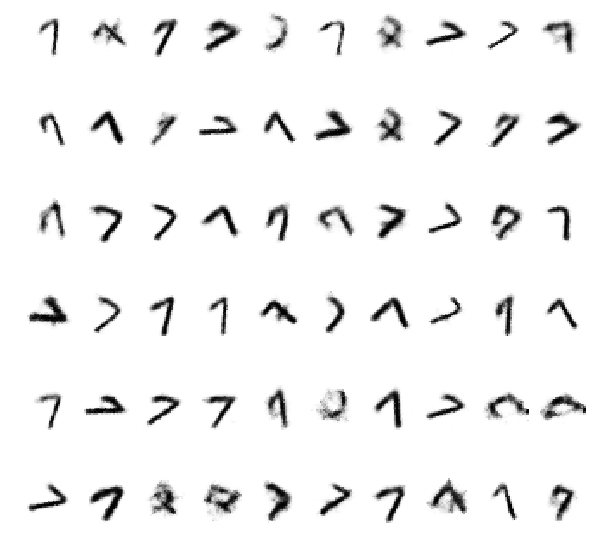

In [64]:
# Training
TRAIN_STEPS = 10000

plt.figure(figsize=(10, 10))
plt_iter = 2000

for i in range(TRAIN_STEPS+1):
    batch = sess.run(next_batch)
    elbo_val, _ = sess.run((elbo, train_step), {x: batch})
    if i% 1000 == 0:
        print('Training Step:' + str(i) + ' Training Loss =  ' + str(elbo_val) +
             ' Test Loss = ' +  str(sess.run(elbo, {x: test_data_input})))
    if i% plt_iter == 0:
        test_samples = sess.run(samples)
        for j in range(10):
            ax=plt.subplot2grid((math.floor(TRAIN_STEPS / plt_iter)+1, 10), (math.floor(i / plt_iter), j))
            plt.imshow(test_samples[j], cmap=plt.get_cmap('gray_r'))
            plt.axis('off')        

In [87]:
seed = sess.run(prior.sample(1))[0]
print(seed)

[ 1.5407324   0.13195458 -1.0961748   1.4224273 ]


[-5.          0.13195458 -1.0961748   1.4224273 ]
[-4.5         0.13195458 -1.0961748   1.4224273 ]
[-4.          0.13195458 -1.0961748   1.4224273 ]
[-3.5         0.13195458 -1.0961748   1.4224273 ]
[-3.          0.13195458 -1.0961748   1.4224273 ]
[-2.5         0.13195458 -1.0961748   1.4224273 ]
[-2.          0.13195458 -1.0961748   1.4224273 ]
[-1.5         0.13195458 -1.0961748   1.4224273 ]
[-1.          0.13195458 -1.0961748   1.4224273 ]
[-0.5         0.13195458 -1.0961748   1.4224273 ]
[ 0.          0.13195458 -1.0961748   1.4224273 ]
[ 0.5         0.13195458 -1.0961748   1.4224273 ]
[ 1.          0.13195458 -1.0961748   1.4224273 ]
[ 1.5         0.13195458 -1.0961748   1.4224273 ]
[ 2.          0.13195458 -1.0961748   1.4224273 ]
[ 2.5         0.13195458 -1.0961748   1.4224273 ]
[ 3.          0.13195458 -1.0961748   1.4224273 ]
[ 3.5         0.13195458 -1.0961748   1.4224273 ]
[ 4.          0.13195458 -1.0961748   1.4224273 ]
[ 4.5         0.13195458 -1.0961748   1.4224273 ]


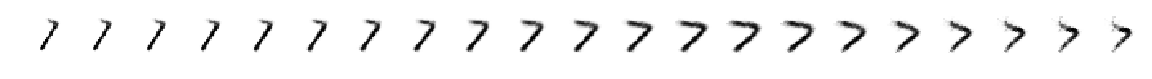

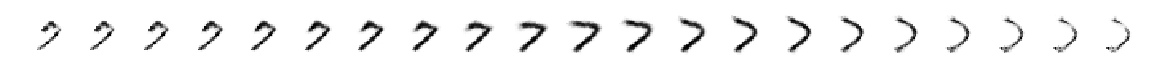

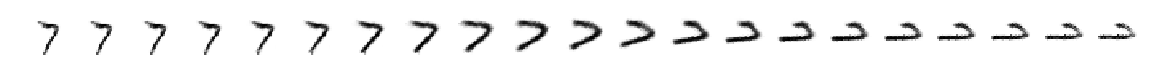

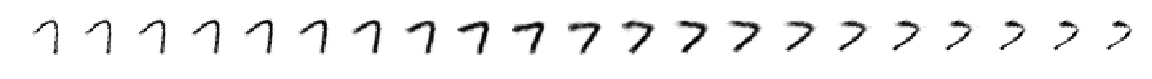

In [89]:
for dim in range(code_size):
    seq = np.zeros((0, code_size))
    for rv in range(-10, 11):
        new_code = np.array(seed)
        new_code[dim] = rv/2
        print(new_code)
        seq = np.vstack((seq , new_code))
    samples = decoder(tf.constant(np.float32(seq))).mean()
    dim_samples = sess.run(samples)
#     print(dim_samples.shape)
    plt.figure(figsize=(20, 20))    
    plt.title('Dim: '+ str(dim))
    for j in range(len(dim_samples)):
        ax=plt.subplot2grid((1, 21), (0, j))
        plt.imshow(dim_samples[j], cmap=plt.get_cmap('gray_r'))
        plt.axis('off')

#### As shown on the visualization above, we can recognize the 3rd row has some artificial effect there. The images rotate significantly as we increase the value from -5.0 to 5.0.